# Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os


import CASBI.preprocessing as preprocessing

# Preprocessing

In this notebook we show how to genereate the main files needed to create the input for the inference, also known as `Template Library` (For more details, see the :class:`CASBI.create_template_library.TemplateLibrary` class.).
The main preprocessing component are:

* Files (.npz): numpy array that are obtain directly from the simulations using the `pynbody` library. 
* Preprocessing file (.npz): It saves aggregated information of Galaxy Mass, Number of stars, [Fe/H] and [O/Fe] in the preprocess_dir. 
* Dataframe (pd.Dataframe): contains the star mass, the infall time and maximum `[Fe/H]` and `[O\Fe]` of each galaxy in the simulations. It is used for the sampling scheme. 


In [2]:
def extract_numeric_part(s):
    return int(s[-5:])

path_uhd = '/mnt/storage/_data/nihao/nihao_uhd'
sim_name = ['8.26e11_zoom_2_new_run/?.??e??.0????', 
            'g2.79e12_3x6/?.??e??.0????', 
            'g1.12e12_3x9/?.??e??.0????',
            'g6.96e11_3x9/?.??e??.0????',
            'g7.08e11_5x10/?.??e??.0????',
            'g7.55e11_3x9/?.??e??.0????']
#we want the last snapshot for each simulations, so the .0???? with the highest value
sim_path = [sorted(glob.glob(os.path.join(path_uhd, sim)), key=extract_numeric_part)[-1] for sim in sim_name   ]

#quick spot check
sim_path

['/mnt/storage/_data/nihao/nihao_uhd/8.26e11_zoom_2_new_run/8.26e11.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x6/2.79e12.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g1.12e12_3x9/1.12e12.02000',
 '/mnt/storage/_data/nihao/nihao_uhd/g6.96e11_3x9/6.96e11.01024',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.08e11_5x10/7.08e11.01024',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.55e11_3x9/7.55e11.01024']

In [6]:
# CREATION OF THE Files from the simulations
# it can take some time to generate the files

file_path = '/mnt/storage/giuseppe_data/data/casbi_uhd/files/'
preprocessing.gen_files(sim_path=sim_path, file_path=file_path, position_flag=True)

In [7]:
# CREATION OF PREPROCESSING FILE AND DATAFRAME

file_dir = '/mnt/storage/giuseppe_data/data/casbi_uhd/files/'
preprocessing_dir = '/mnt/storage/giuseppe_data/data/casbi_uhd/'

preprocess_file_path = preprocessing.preprocess(file_dir=file_dir, preprocess_dir=preprocessing_dir)
print('Preprocesse file location:', preprocess_file_path)

100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Preprocesse file location: /mnt/storage/giuseppe_data/data/casbi_uhd/preprocess_file.npz


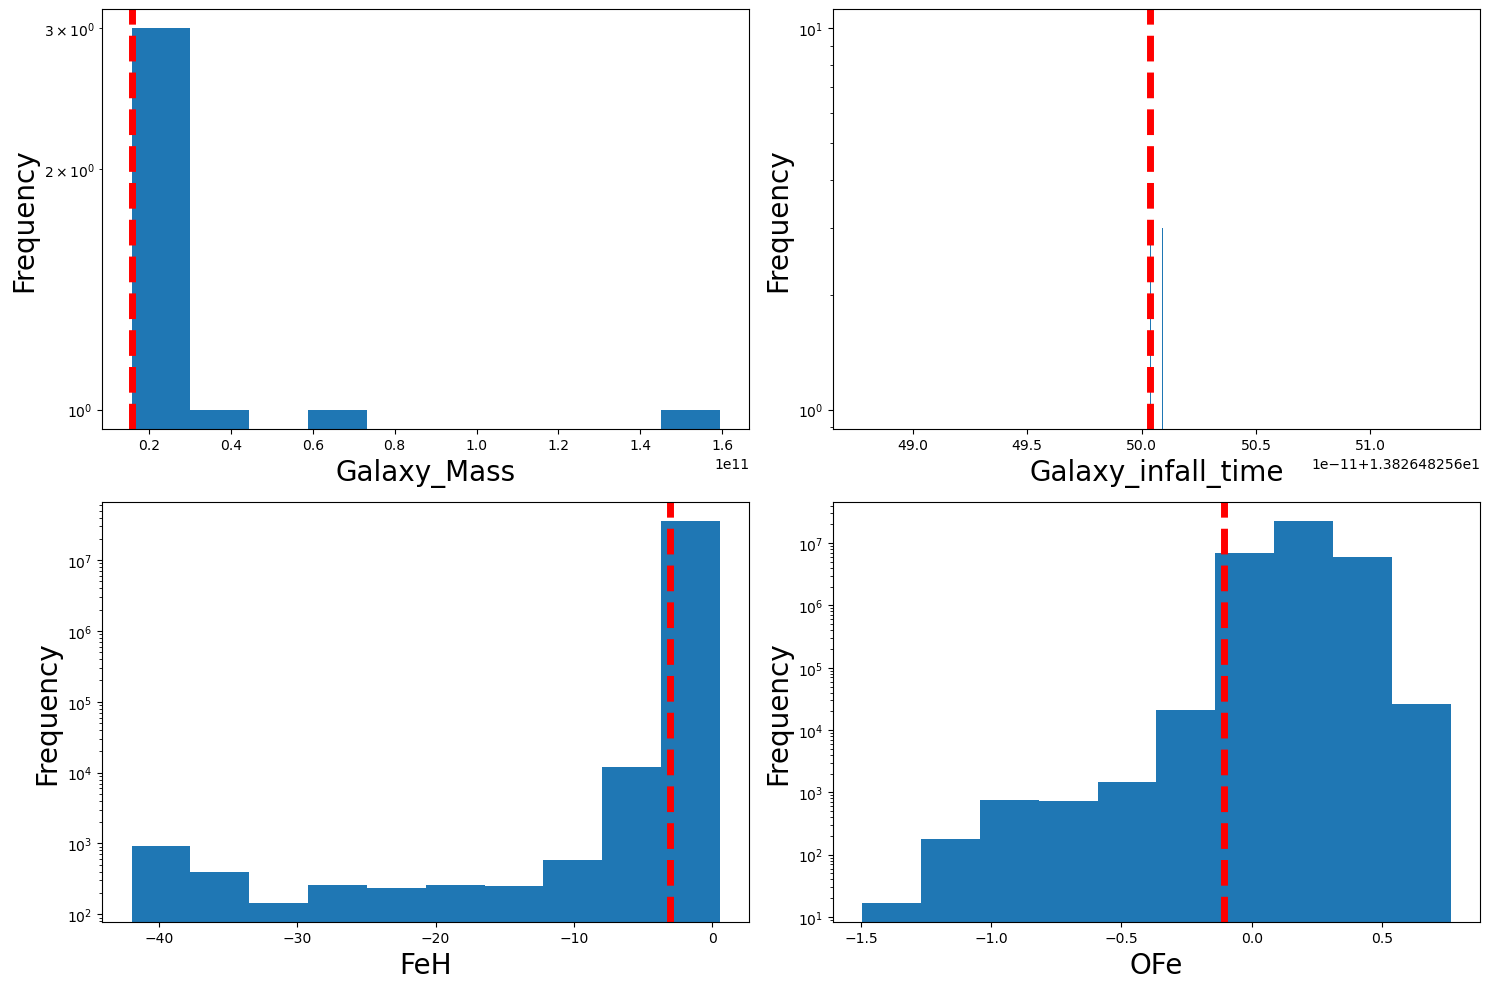

In [8]:
#Spot check to see that the outlier chemical outlier removal is not too aggressive 

# Load the .npz file
preprocessing_file = np.load(preprocess_file_path, allow_pickle=True)

# Get the keys from the .npz file
keys = preprocessing_file.files

# Determine the number of rows and columns for the subplots
n_keys = len(keys)
n_cols = 2
n_rows = (n_keys + 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histogram and vertical line for each key
for i, key in enumerate(keys):
    data = preprocessing_file[key]
    axes[i].hist(data)
    axes[i].set_yscale('log')
    percentile_01 = np.percentile(data, 0.1)
    axes[i].axvline(percentile_01, color='r', linestyle='dashed', linewidth=5)
    axes[i].set_xlabel(key, fontsize=20)
    axes[i].set_ylabel('Frequency', fontsize=20)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
file_dir = '/mnt/storage/giuseppe_data/data/casbi_uhd/files/'
preprocessing_dir = '/mnt/storage/giuseppe_data/data/casbi_uhd/'

df = preprocessing.gen_dataframe(file_dir=file_dir, dataframe_path = preprocessing_dir)
df

,star_mass,infall_time,Galaxy_name,max_feh,max_ofe
0,6.323989e+10,13.826483,1.12e12.02000,0.537806,0.763695
1,1.594477e+11,13.826483,2.79e12.02000,0.552946,0.750022
2,1.576569e+10,13.826483,6.96e11.01024,0.177300,0.756730
3,2.003004e+10,13.826483,7.08e11.01024,0.369079,0.756730
4,2.720325e+10,13.826483,7.55e11.01024,0.362711,0.756730
5,3.181181e+10,13.826483,8.26e11.02000,0.455926,0.750022


# Visualize the whole abundance plane for the galaxy 

In [10]:
#let's set the boundery of our visulization to the same one of the training set
#we have cut the lower 0.1 percentile in both feh and ofe 
preprocessin_file_training_set = np.load('/mnt/storage/giuseppe_data/data/casbi_rewriting/preprocess_file.npz', allow_pickle=True)
min_feh, max_feh = np.percentile(preprocessin_file_training_set['FeH'], [0.1, 100])
min_ofe, max_ofe = np.percentile(preprocessin_file_training_set['OFe'], [0.1, 100])

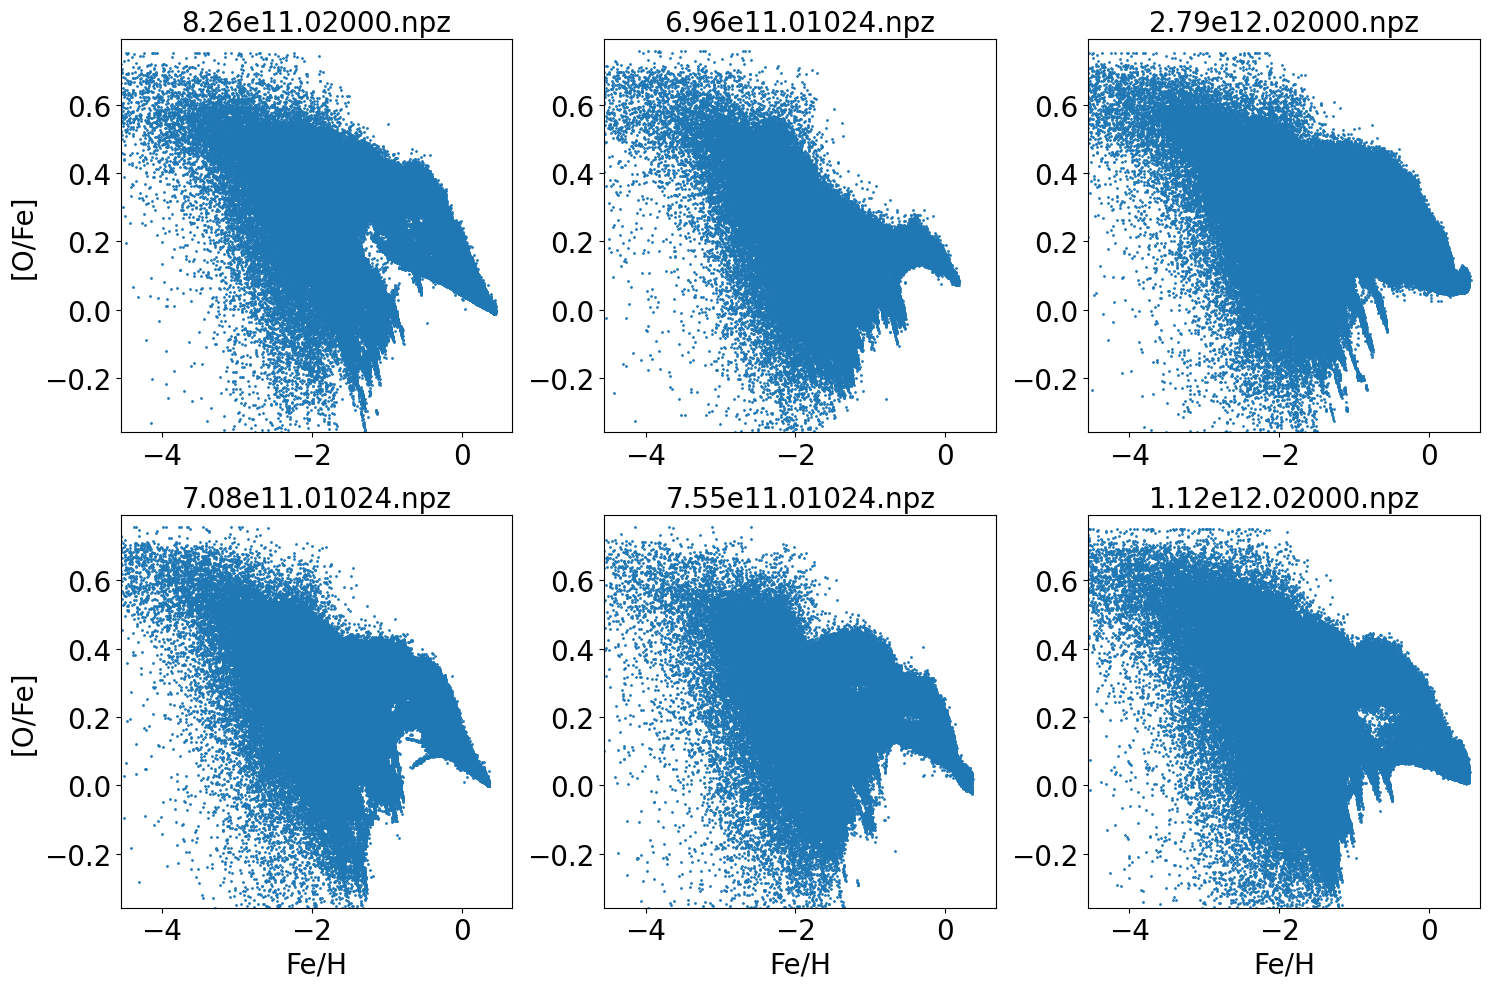

In [11]:
# Assuming df, file_dir, file_path, min_feh, max_feh, min_ofe, max_ofe are defined

fig = plt.figure(figsize=(15, 10))

for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]

    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    feh = galaxy['feh']
    ofe = galaxy['ofe']

    ax = fig.add_subplot(2, 3, i + 1)
    ax.scatter(feh, ofe, s=1)
    
    # Set x-label only on the lower row
    if i // 3 == 1:
        ax.set_xlabel('Fe/H', fontsize=20)
    
    # Set y-label only on the left column
    if i % 3 == 0:
        ax.set_ylabel('[O/Fe]', fontsize=20)
    
    ax.set_xlim(min_feh, max_feh)
    ax.set_ylim(min_ofe, max_ofe)
    ax.set_title(galaxy_path, fontsize=20)
    
    # Set the font size of the ticks to 14
    ax.tick_params(axis='both', which='major', labelsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]
    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    # feh = galaxy['feh']
    # ofe = galaxy['ofe']
    # galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    break

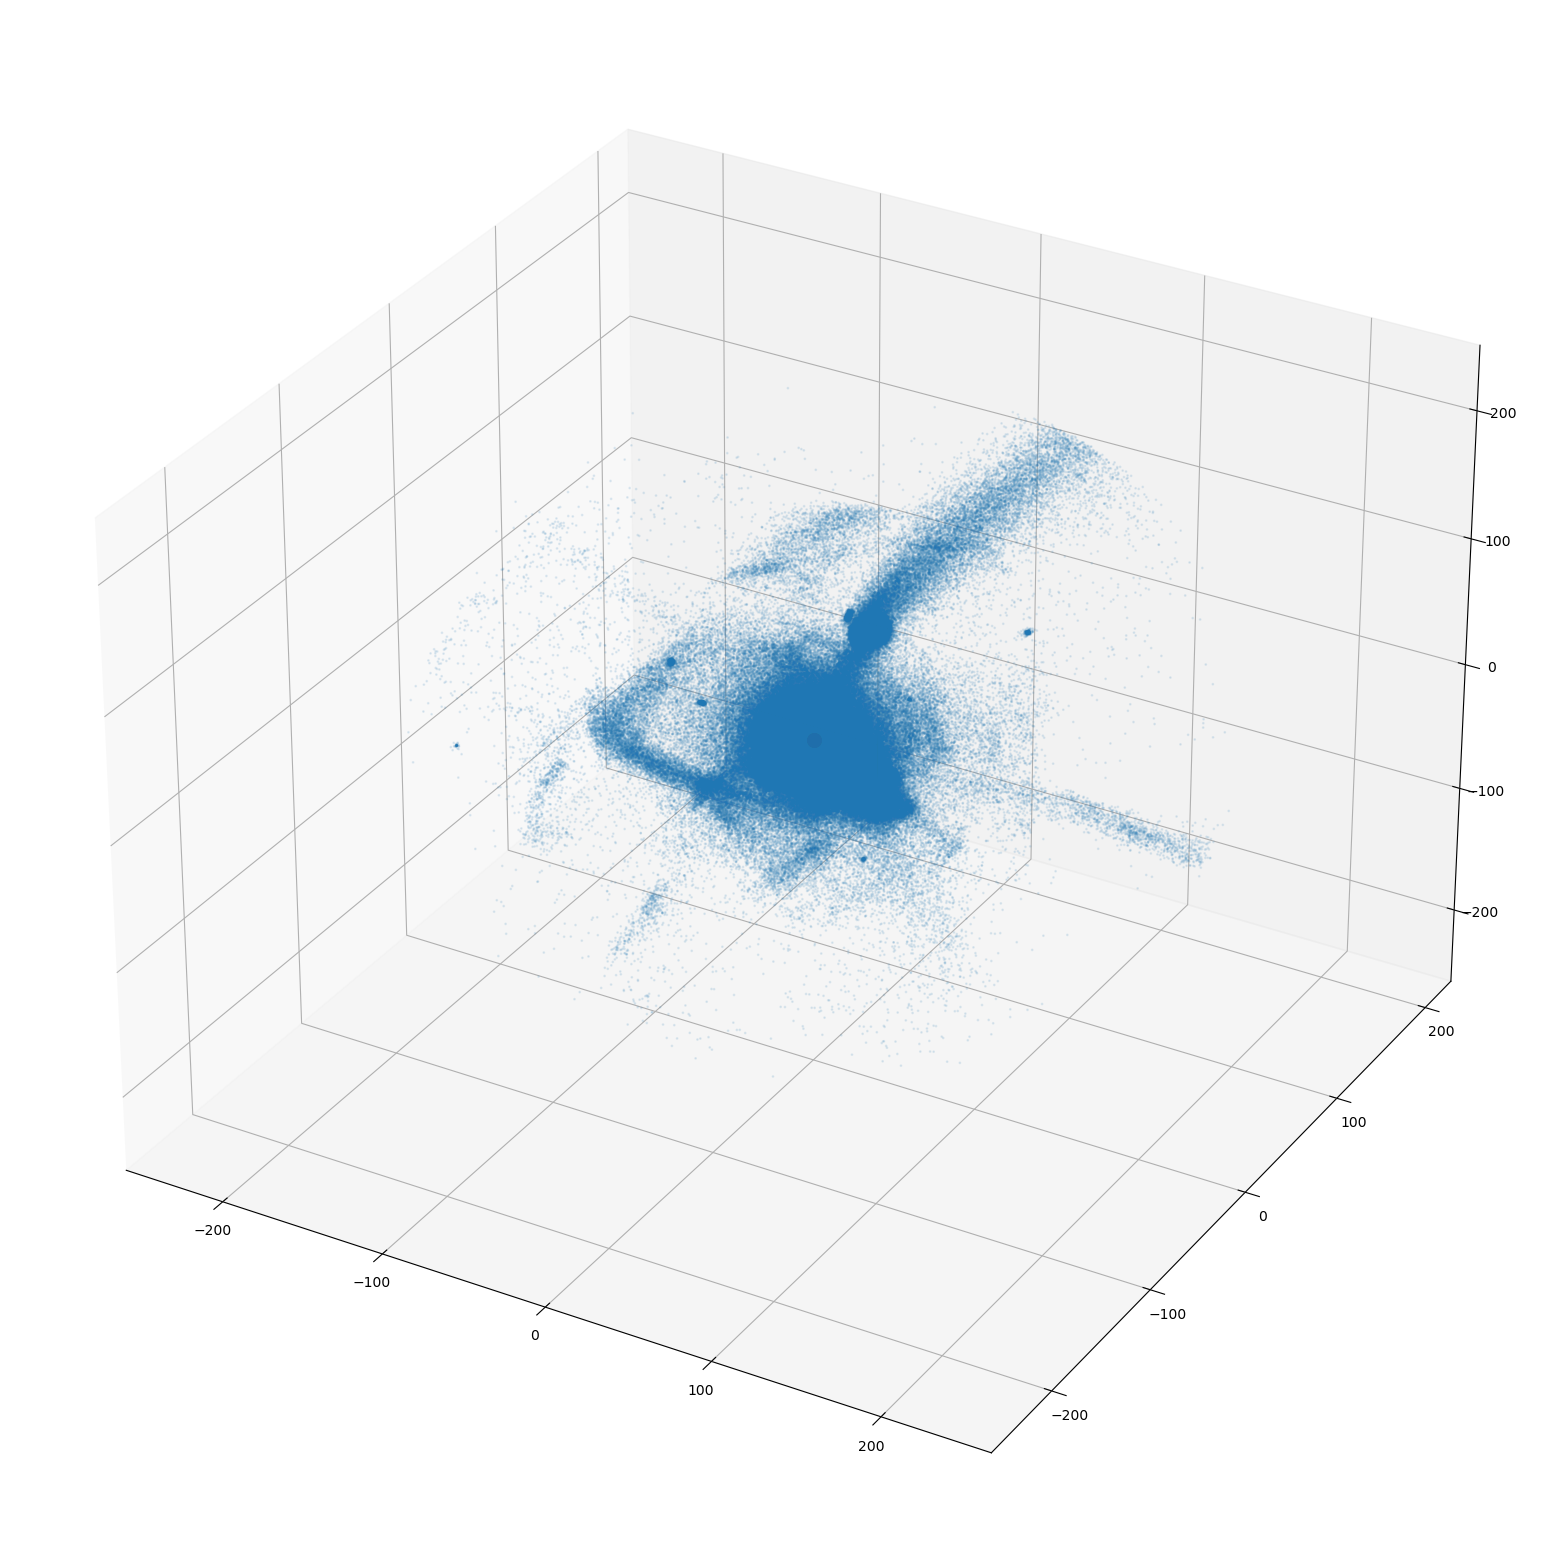

In [17]:
from audioop import add


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(galaxy['position'][:, 0], galaxy['position'][:, 1], galaxy['position'][:, 2], s=1, alpha=0.1)
# ax.scatter(0, 0, 0, c='r', s=100)   

/tmp/ipykernel_1829131/1737066811.py:20: RuntimeWarning: divide by zero encountered in log
  global_max = max(global_max, np.log(galaxy_2d_hist).max())
/tmp/ipykernel_1829131/1737066811.py:34: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)


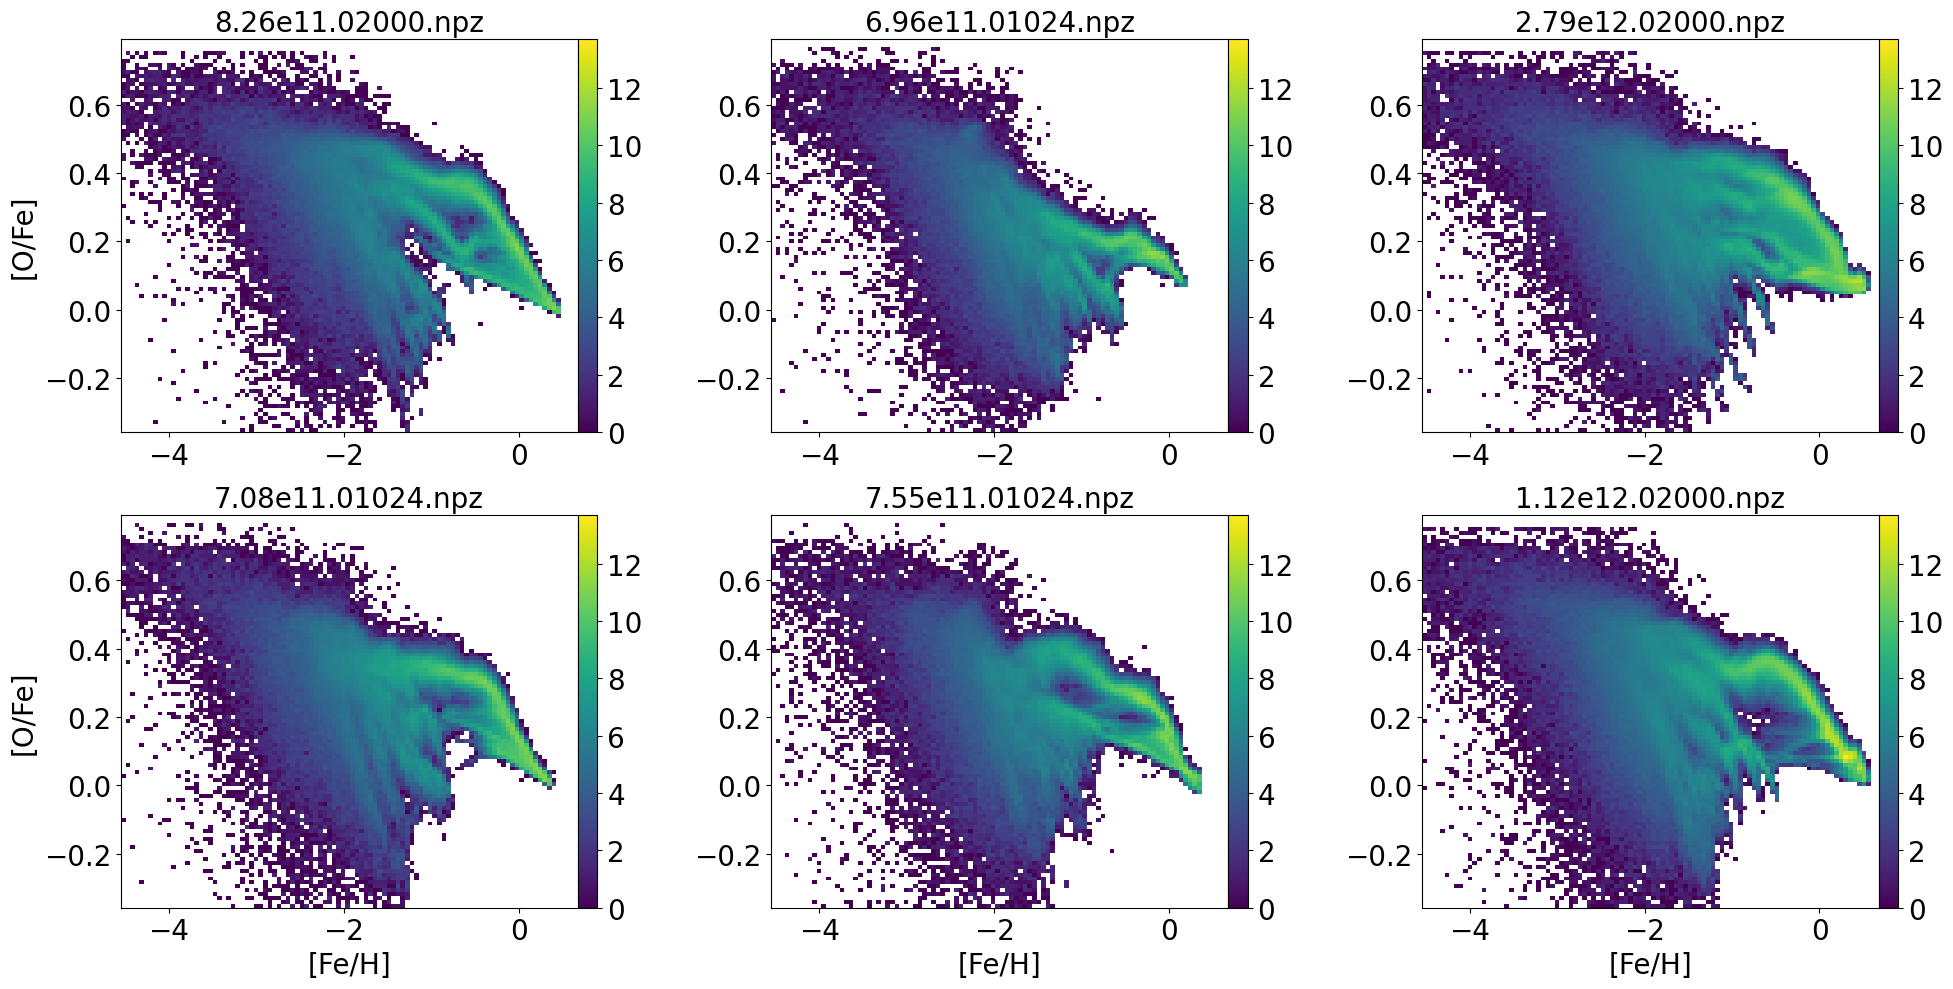

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming df, file_dir, file_path, min_feh, max_feh, min_ofe, max_ofe are defined

# Step 1: Determine the color limits
global_min = float('inf')
global_max = float('-inf')

for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]
    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    feh = galaxy['feh']
    ofe = galaxy['ofe']
    galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    
    # Update global min and max
    global_min = min(global_min, np.log(galaxy_2d_hist[galaxy_2d_hist > 0]).min())
    global_max = max(global_max, np.log(galaxy_2d_hist).max())

# Step 2: Plot the data with colorbars
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]
    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    feh = galaxy['feh']
    ofe = galaxy['ofe']
    galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])

    ax = axes[i]
    im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)
    
    # Set x-label only on the lower row
    if i // 3 == 1:
        ax.set_xlabel('[Fe/H]', fontsize=20)
    
    # Set y-label only on the left column
    if i % 3 == 0:
        ax.set_ylabel('[O/Fe]', fontsize=20)
    
    ax.set_xlim(min_feh, max_feh)
    ax.set_ylim(min_ofe, max_ofe)
    ax.set_title(galaxy_path, fontsize=20)
    
    # Set the font size of the ticks to 20
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Add colorbar to the top of each subplot
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0)
    cbar.ax.tick_params(labelsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

# Visualize the abundance plane after the radial cut to remove the bulge and disk

/tmp/ipykernel_1829131/1737066811.py:20: RuntimeWarning: divide by zero encountered in log
  global_max = max(global_max, np.log(galaxy_2d_hist).max())
/tmp/ipykernel_1829131/1737066811.py:34: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)


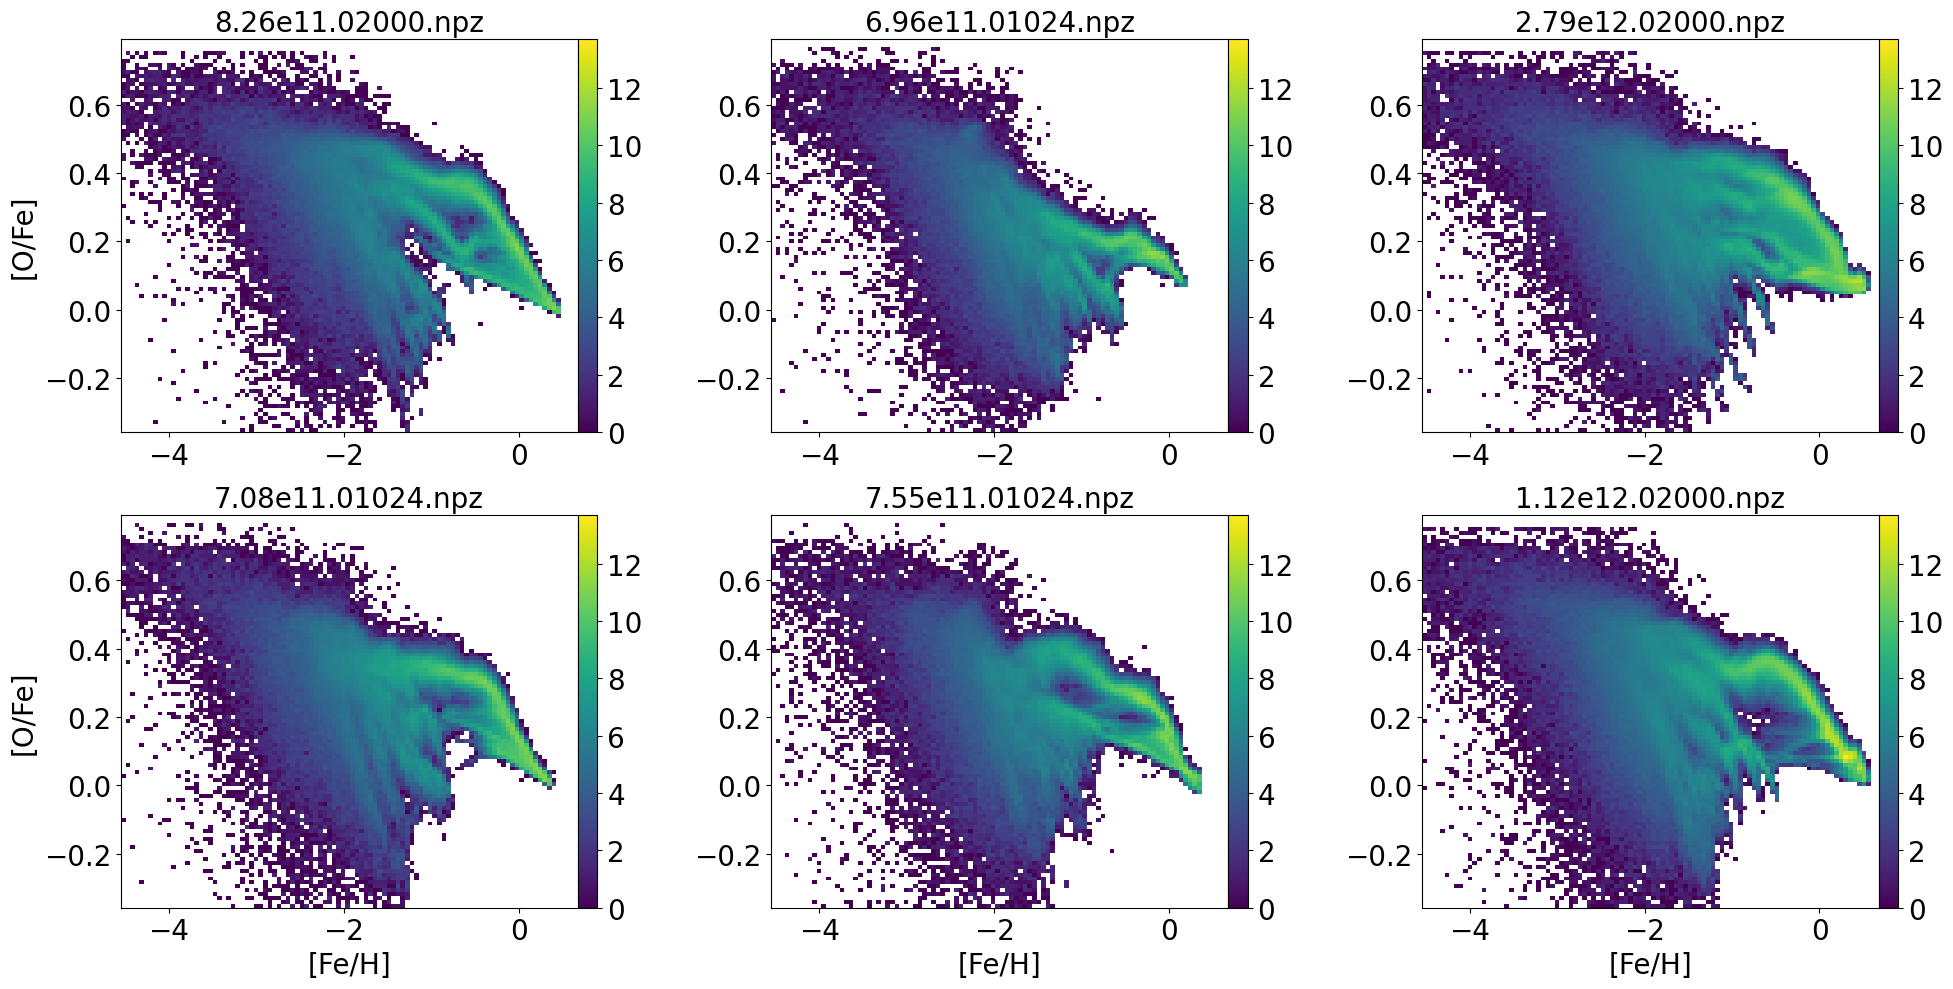

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming df, file_dir, file_path, min_feh, max_feh, min_ofe, max_ofe are defined

# Step 1: Determine the color limits
global_min = float('inf')
global_max = float('-inf')

for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]
    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    feh = galaxy['feh']
    ofe = galaxy['ofe']
    galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
    
    # Update global min and max
    global_min = min(global_min, np.log(galaxy_2d_hist[galaxy_2d_hist > 0]).min())
    global_max = max(global_max, np.log(galaxy_2d_hist).max())

# Step 2: Plot the data with colorbars
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i in range(len(df)):
    galaxy_path = os.listdir(file_dir)[i]
    galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
    feh = galaxy['feh']
    ofe = galaxy['ofe']
    galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])

    ax = axes[i]
    im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)
    
    # Set x-label only on the lower row
    if i // 3 == 1:
        ax.set_xlabel('[Fe/H]', fontsize=20)
    
    # Set y-label only on the left column
    if i % 3 == 0:
        ax.set_ylabel('[O/Fe]', fontsize=20)
    
    ax.set_xlim(min_feh, max_feh)
    ax.set_ylim(min_ofe, max_ofe)
    ax.set_title(galaxy_path, fontsize=20)
    
    # Set the font size of the ticks to 20
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Add colorbar to the top of each subplot
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0)
    cbar.ax.tick_params(labelsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
def radius(galaxy):
    r = np.sqrt(np.sum(galaxy['position']** 2, axis=1))
    return r

def buldge_filter(galaxy, r_bulge):
    return radius(galaxy) > r_bulge
def disk_filter(galaxy, z_disk, r_disk):
    return (np.abs(galaxy['position'][:, 2]) > z_disk)&(radius(galaxy) > r_disk)
def halo_mask(galaxy, r_bulge, z_disk, r_disk):
    return buldge_filter(galaxy, r_bulge) & disk_filter(galaxy, z_disk, r_disk)

def plot_function(galaxy_path, r_bulge = 0., z_disk = 0., r_disk = 0.):
    # Step 1: Determine the color limits
    global_min = float('inf')
    global_max = float('-inf')

    for i in range(len(df)):
        galaxy_path = os.listdir(file_dir)[i]
        galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
        feh = galaxy['feh'][halo_mask(galaxy, r_bulge, z_disk, r_disk)]
        ofe = galaxy['ofe'][halo_mask(galaxy, r_bulge, z_disk, r_disk)]
        galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
        
        # Update global min and max
        global_min = min(global_min, np.log(galaxy_2d_hist[galaxy_2d_hist > 0]).min())
        global_max = max(global_max, np.log(galaxy_2d_hist).max())

    # Step 2: Plot the data with colorbars
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(len(df)):
        galaxy_path = os.listdir(file_dir)[i]
        galaxy = np.load(os.path.join(file_path, galaxy_path), allow_pickle=True)
        feh = galaxy['feh'][halo_mask(galaxy, r_bulge, z_disk, r_disk)]
        ofe = galaxy['ofe'][halo_mask(galaxy, r_bulge, z_disk, r_disk)]
        galaxy_2d_hist, _, _ = np.histogram2d(feh, ofe, bins=100, range=[[min_feh, max_feh], [min_ofe, max_ofe]])

        ax = axes[i]
        im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)
        
        # Set x-label only on the lower row
        if i // 3 == 1:
            ax.set_xlabel('[Fe/H]', fontsize=20)
        
        # Set y-label only on the left column
        if i % 3 == 0:
            ax.set_ylabel('[O/Fe]', fontsize=20)
        
        ax.set_xlim(min_feh, max_feh)
        ax.set_ylim(min_ofe, max_ofe)
        ax.set_title(galaxy_path, fontsize=20)
        
        # Set the font size of the ticks to 20
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        # Add colorbar to the top of each subplot
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', location='right', pad=0)
        cbar.ax.tick_params(labelsize=20)

    # Adjust layout
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1829131/2651531679.py:26: RuntimeWarning: divide by zero encountered in log
  global_max = max(global_max, np.log(galaxy_2d_hist).max())
/tmp/ipykernel_1829131/2651531679.py:40: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)


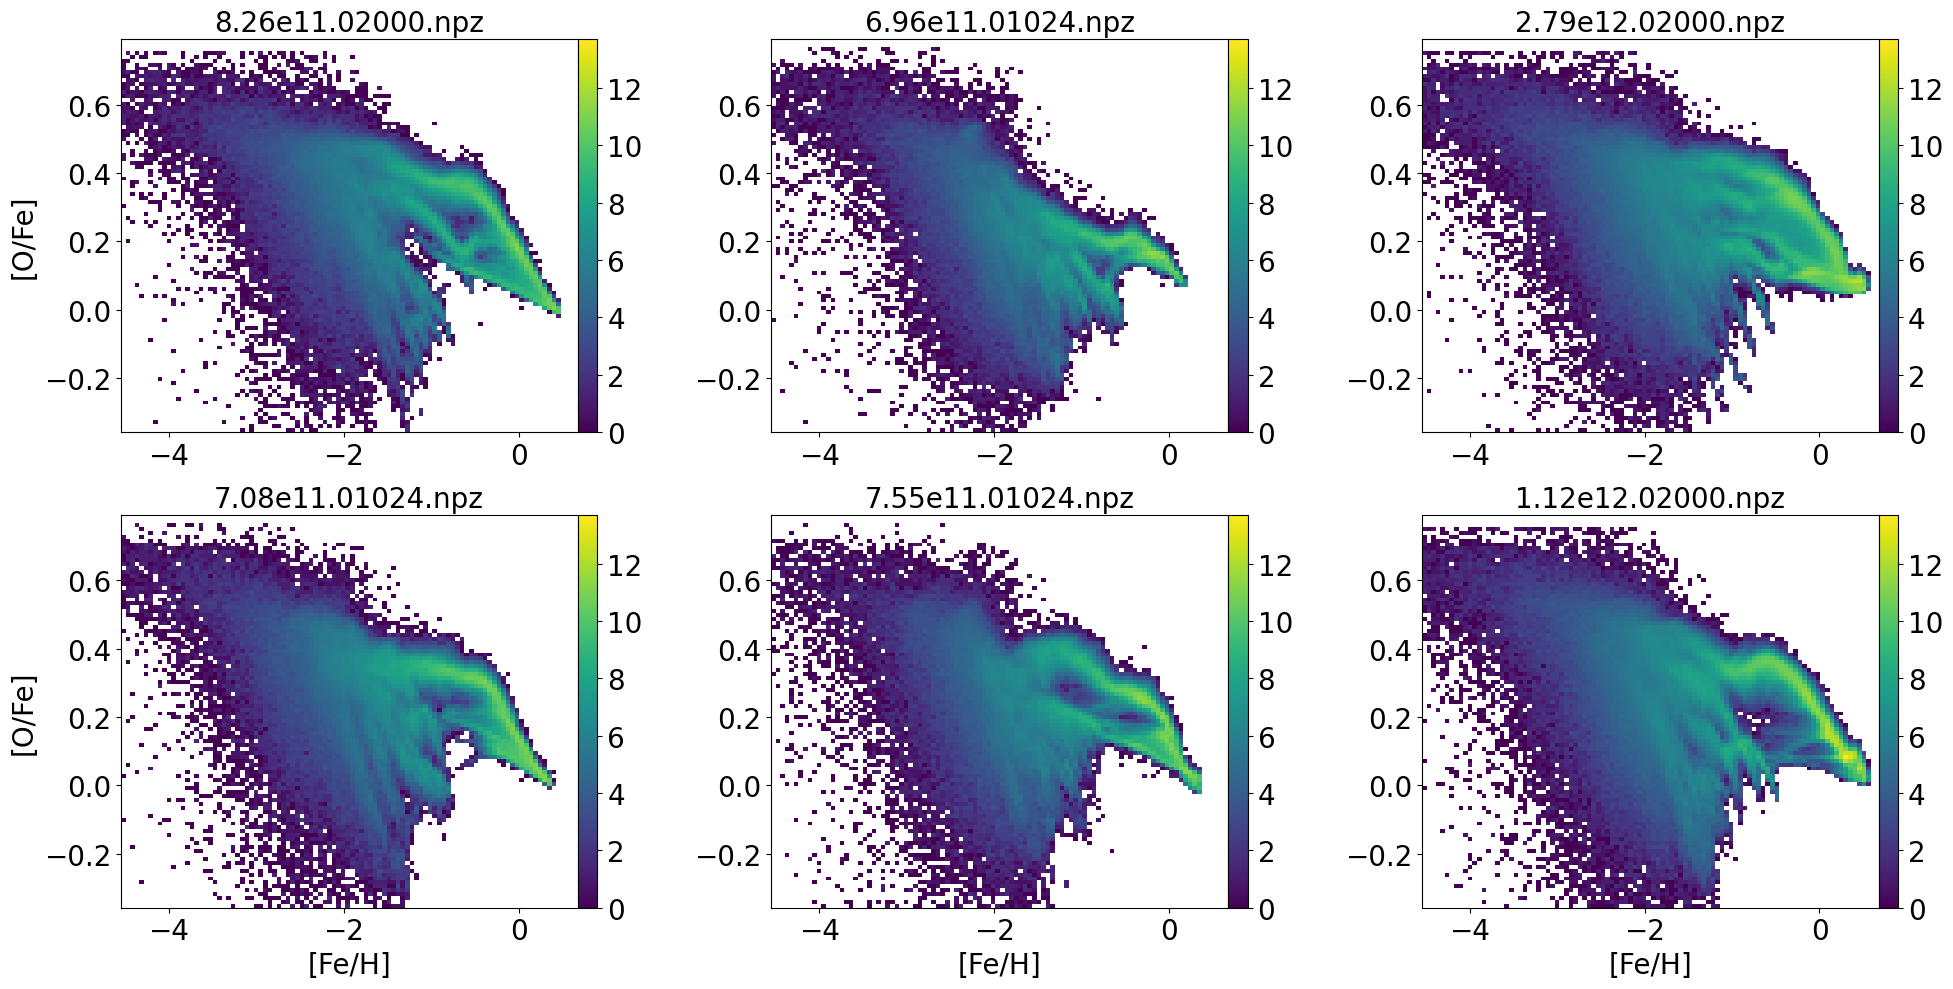

In [34]:
plot_function(galaxy_path=galaxy_path, )

/tmp/ipykernel_1829131/2651531679.py:26: RuntimeWarning: divide by zero encountered in log
  global_max = max(global_max, np.log(galaxy_2d_hist).max())
/tmp/ipykernel_1829131/2651531679.py:40: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(galaxy_2d_hist.T), origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='viridis', vmin=global_min, vmax=global_max)


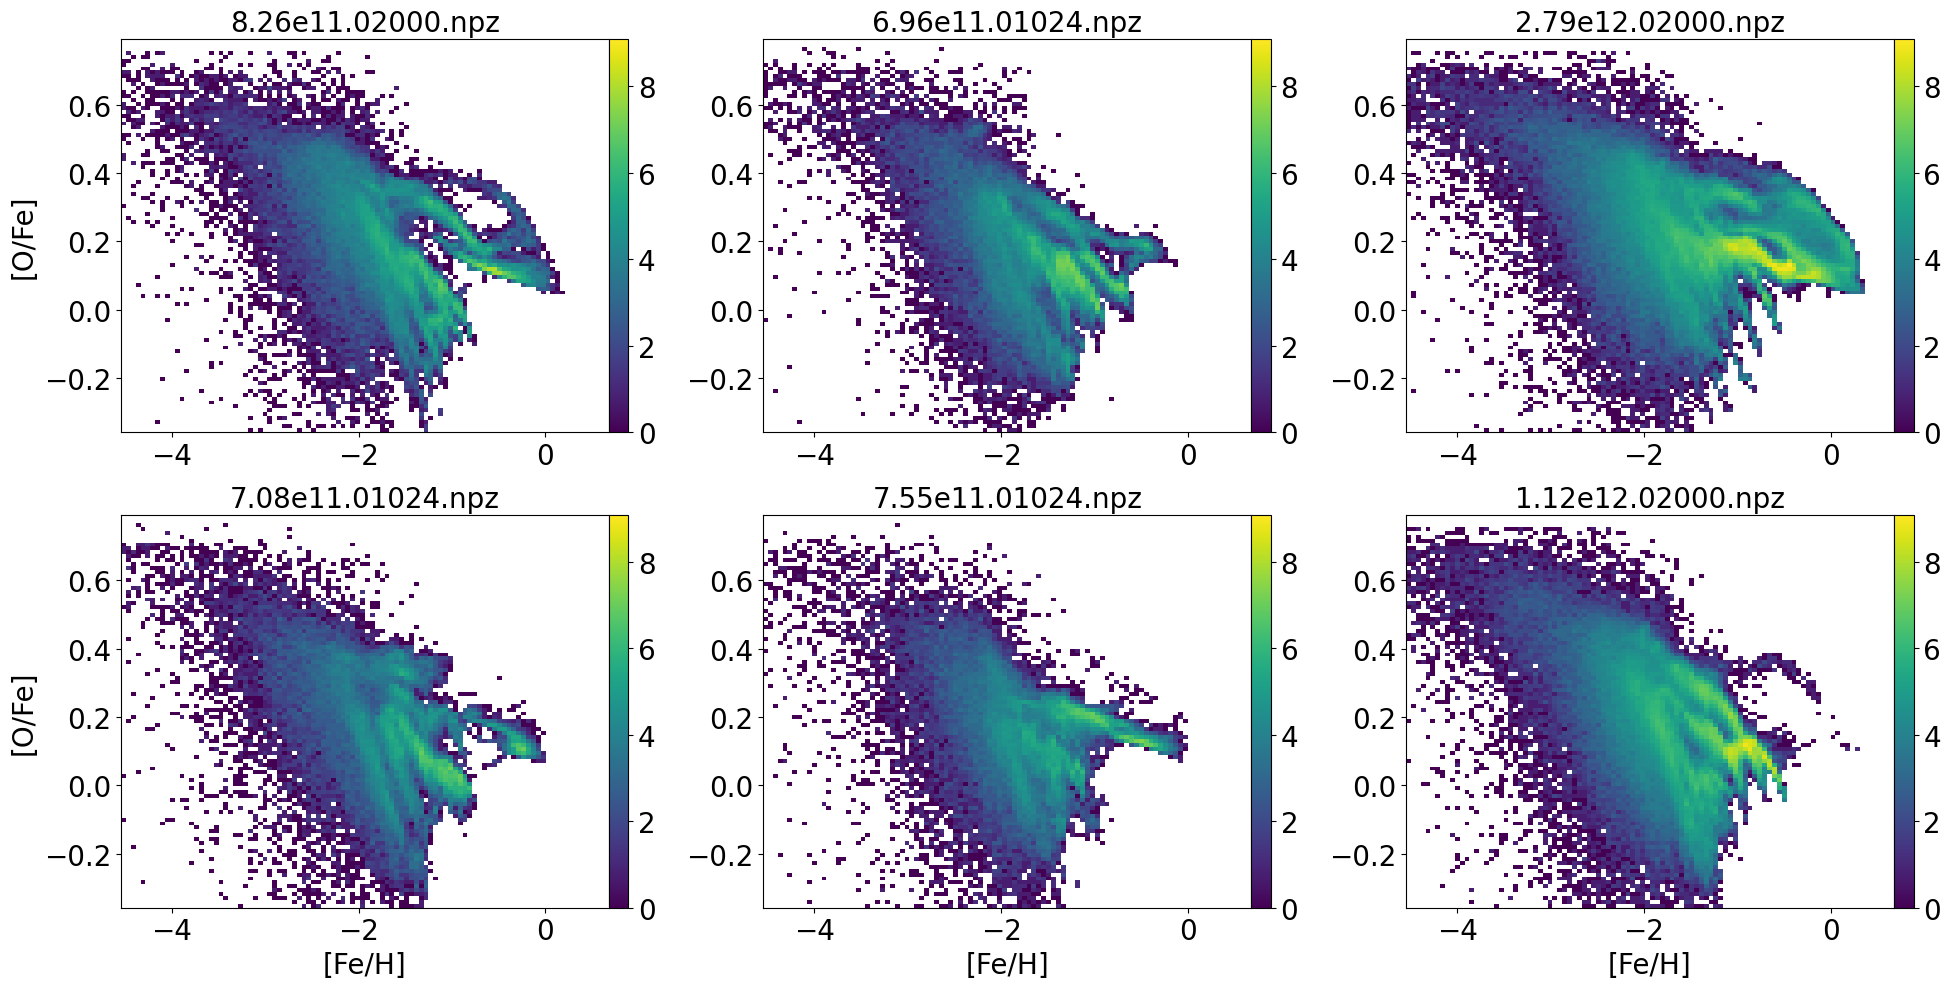

In [36]:
plot_function(galaxy_path=galaxy_path, r_bulge=2, r_disk=20, z_disk=2)

# Get the merging tree

In [3]:
import ytree
import pandas as pd
from tqdm import tqdm

In [4]:
path_ytree_files_z0 = [s+'.parameter' for s in sim_path]
path_ytree_files_z0 

['/mnt/storage/_data/nihao/nihao_uhd/8.26e11_zoom_2_new_run/8.26e11.02000.parameter',
 '/mnt/storage/_data/nihao/nihao_uhd/g2.79e12_3x6/2.79e12.02000.parameter',
 '/mnt/storage/_data/nihao/nihao_uhd/g1.12e12_3x9/1.12e12.02000.parameter',
 '/mnt/storage/_data/nihao/nihao_uhd/g6.96e11_3x9/6.96e11.01024.parameter',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.08e11_5x10/7.08e11.01024.parameter',
 '/mnt/storage/_data/nihao/nihao_uhd/g7.55e11_3x9/7.55e11.01024.parameter']

In [6]:
i = 1
single_tree = ytree.load(path_ytree_files_z0[i])
fn = single_tree.save_arbor()
single_tree = ytree.load(fn)

if i==0:
    single_tree.add_alias_field('mass','Mhalo',units='Msun/h')

Getting fields [1 / ~27]: 100%|██████████| 1168/1168 [01:04<00:00, 18.04it/s]
yt : [INFO     ] 2025-01-28 08:50:13,546 Saving field data to yt dataset: arbor/arbor_0000.h5.
Getting fields [2 / ~6]: 100%|██████████| 8969/8969 [01:38<00:00, 91.22it/s] 
yt : [INFO     ] 2025-01-28 08:51:59,129 Saving field data to yt dataset: arbor/arbor_0001.h5.
Getting fields [3 / ~3]: 100%|██████████| 21774/21774 [00:33<00:00, 657.62it/s] 
yt : [INFO     ] 2025-01-28 08:52:36,139 Saving field data to yt dataset: arbor/arbor_0002.h5.
yt : [INFO     ] 2025-01-28 08:52:36,285 Saving field data to yt dataset: arbor/arbor.h5.


In [6]:
single_tree.field_list

['halo_id',
 'hostHalo',
 'numSubStruct',
 'mass',
 'npart',
 'position_x',
 'position_y',
 'position_z',
 'velocity_x',
 'velocity_y',
 'velocity_z',
 'virial_radius',
 'Rmax',
 'r2',
 'mbp_offset',
 'com_offset',
 'Vmax',
 'v_esc',
 'velocity_dispersion',
 'spin_parameter',
 'lambdaE',
 'Lx',
 'Ly',
 'Lz',
 'b',
 'c',
 'Eax',
 'Eay',
 'Eaz',
 'Ebx',
 'Eby',
 'Ebz',
 'Ecx',
 'Ecy',
 'Ecz',
 'ovdens',
 'nbins',
 'fMhires',
 'kinetic_energy',
 'potential_energy',
 'SurfP',
 'Phi0',
 'cNFW',
 'n_gas',
 'M_gas',
 'lambda_gas',
 'lambdaE_gas',
 'Lx_gas',
 'Ly_gas',
 'Lz_gas',
 'b_gas',
 'c_gas',
 'Eax_gas',
 'Eay_gas',
 'Eaz_gas',
 'Ebx_gas',
 'Eby_gas',
 'Ebz_gas',
 'Ecx_gas',
 'Ecy_gas',
 'Ecz_gas',
 'Ekin_gas',
 'Epot_gas',
 'n_star',
 'M_star',
 'lambda_star',
 'lambdaE_star',
 'Lx_star',
 'Ly_star',
 'Lz_star',
 'b_star',
 'c_star',
 'Eax_star',
 'Eay_star',
 'Eaz_star',
 'Ebx_star',
 'Eby_star',
 'Ebz_star',
 'Ecx_star',
 'Ecy_star',
 'Ecz_star',
 'Ekin_star',
 'Epot_star',
 'redshif

In [ ]:
single_tree.data_file

In [7]:
list(single_tree)

[TreeNode[0],
 TreeNode[1],
 TreeNode[2],
 TreeNode[3],
 TreeNode[4],
 TreeNode[5],
 TreeNode[6],
 TreeNode[7],
 TreeNode[8],
 TreeNode[9],
 TreeNode[10],
 TreeNode[11],
 TreeNode[12],
 TreeNode[13],
 TreeNode[14],
 TreeNode[15],
 TreeNode[16],
 TreeNode[17],
 TreeNode[18],
 TreeNode[19],
 TreeNode[20],
 TreeNode[21],
 TreeNode[22],
 TreeNode[23],
 TreeNode[24],
 TreeNode[25],
 TreeNode[26],
 TreeNode[27],
 TreeNode[28],
 TreeNode[29],
 TreeNode[30],
 TreeNode[31],
 TreeNode[32],
 TreeNode[33],
 TreeNode[34],
 TreeNode[35],
 TreeNode[36],
 TreeNode[37],
 TreeNode[38],
 TreeNode[39],
 TreeNode[40],
 TreeNode[41],
 TreeNode[42],
 TreeNode[43],
 TreeNode[44],
 TreeNode[45],
 TreeNode[46],
 TreeNode[47],
 TreeNode[48],
 TreeNode[49],
 TreeNode[50],
 TreeNode[51],
 TreeNode[52],
 TreeNode[53],
 TreeNode[54],
 TreeNode[55],
 TreeNode[56],
 TreeNode[57],
 TreeNode[58],
 TreeNode[59],
 TreeNode[60],
 TreeNode[61],
 TreeNode[62],
 TreeNode[63],
 TreeNode[64],
 TreeNode[65],
 TreeNode[66],
 Tree

In [13]:
first_node = list(single_tree)[0]
print(first_node['mass'])
print(first_node['halo_id'])

2098340000000.0 Msun/h
0


In [7]:
def get_arbor_merge_history(isolated_TreeNode):
    
    df = pd.DataFrame(columns = ['merge_index', 'merge_header', 'redshift',  'mass_merge_header', 
                                 'mass_progenitor_parallel_to_merge_header', 
                                 'merge_branch', 'progenitor_parallel_to_merge_branch'])

    #first we get the main progenitor of the arbor, this is in root -> leaves order
    progenitor_root_to_leaves = list(isolated_TreeNode['prog'])

    #we want the leaves -> root order for all of our data
    progenitor_leaves_to_root = progenitor_root_to_leaves[::-1]
    
   
    merge_index = 0
    #now we prune the arbor and keep the branch that are not the progenitor of the arbor, we will need the index i
    for i in tqdm(range( len(progenitor_leaves_to_root)) ):
        
        #if the difference in the number of nodes bewteen two consecutive node in the progenitor_leaves_to_root is bigger than 1 it means that there is another branch:
        l_i = progenitor_leaves_to_root[i].tree_size
        l_i_old = progenitor_leaves_to_root[i-1].tree_size
        if l_i - l_i_old > 1:
            
            pruned_branches = [j for j in progenitor_leaves_to_root[i]['tree'] if j['uid'] not in progenitor_leaves_to_root[i-1]['tree', 'uid'] ]
            merge_header = [j for j in pruned_branches if j['redshift'] == progenitor_leaves_to_root[i-1]['redshift'] ]
            for m_h in merge_header:
                merge_branch = [j for j in pruned_branches if j['uid'] in m_h['tree', 'uid']]
                redshift_merge_branch = [j['redshift'] for j in merge_branch]
                  
                progenitor_parallel_to_merge_branch = [j for j in progenitor_leaves_to_root[:i] if j['redshift'] <= max(redshift_merge_branch) and j['redshift'] >= min(redshift_merge_branch) ]
                
                df.loc[len(df)] = [merge_index, merge_header, m_h['redshift'], m_h['mass'], progenitor_leaves_to_root[i-1]['mass'], merge_branch[::-1], progenitor_parallel_to_merge_branch]
                
            merge_index += 1
    
    return df

In [8]:
df = get_arbor_merge_history(single_tree[0])


 99%|█████████▉| 224/226 [23:19<00:12,  6.25s/it]


KeyboardInterrupt: 

In [16]:
df.head()

,merge_index,redshift,merge_header,mass_merge_header,mass_progenitor_parallel_to_merge_header,merge_branch,progenitor_parallel_to_merge_branch
3137,172,0.282422,TreeNode[243114],126004000000.0 Msun/h,2261630000000.0 Msun/h,"[TreeNode[253471], TreeNode[258662], TreeNode[...","[TreeNode[258657], TreeNode[253456], TreeNode[..."
2890,161,0.364532,TreeNode[300555],109109000000.0 Msun/h,2173290000000.0 Msun/h,"[TreeNode[352602], TreeNode[347033], TreeNode[...","[TreeNode[1195890], TreeNode[1195692], TreeNod..."
605,49,2.473390,TreeNode[950970],81881300000.0 Msun/h,770531000000.0 Msun/h,"[TreeNode[1184500], TreeNode[1181543], TreeNod...","[TreeNode[1195890], TreeNode[1195692], TreeNod..."
3306,180,0.227970,TreeNode[202089],60496400000.0 Msun/h,2189060000000.0 Msun/h,"[TreeNode[232841], TreeNode[232818], TreeNode[...","[TreeNode[232813], TreeNode[227668], TreeNode[..."
809,55,2.195270,TreeNode[914547],59812300000.0 Msun/h,912782000000.0 Msun/h,"[TreeNode[926726], TreeNode[920635], TreeNode[...","[TreeNode[926725], TreeNode[920618], TreeNode[..."


In [23]:
most_massive_merger_node = df.iloc[2]['merge_header']   
# most_massive_merger_node
most_massive_merger_node['halo']

ArborFieldNotFound: Field not found: "halo" in arbor.h5.

In [28]:
list(most_massive_merger_node.ancestors)[0].data_file

AttributeError: 'TreeNode' object has no attribute 'data_file'

In [8]:
def get_arbor_merge_history(isolated_TreeNode):
    
    df = pd.DataFrame(columns = ['merge_index', 'merge_header', 'redshift', 'halo_id', 'mass_merge_header', 
                                 'mass_progenitor_parallel_to_merge_header', 
                                 ])

    #first we get the main progenitor of the arbor, this is in root -> leaves order
    progenitor_root_to_leaves = list(isolated_TreeNode['prog'])

    #we want the leaves -> root order for all of our data
    progenitor_leaves_to_root = progenitor_root_to_leaves[::-1]
    
   
    merge_index = 0
    #now we prune the arbor and keep the branch that are not the progenitor of the arbor, we will need the index i
    for i in tqdm(range( len(progenitor_leaves_to_root)) ):
        
        #if the difference in the number of nodes bewteen two consecutive node in the progenitor_leaves_to_root is bigger than 1 it means that there is another branch:
        l_i = progenitor_leaves_to_root[i].tree_size
        l_i_old = progenitor_leaves_to_root[i-1].tree_size
        if l_i - l_i_old > 1:
            
            pruned_branches = [j for j in progenitor_leaves_to_root[i]['tree'] if j['uid'] not in progenitor_leaves_to_root[i-1]['tree', 'uid'] ]
            merge_header = [j for j in pruned_branches if j['redshift'] == progenitor_leaves_to_root[i-1]['redshift'] ]
            for m_h in merge_header:
                merge_branch = [j for j in pruned_branches if j['uid'] in m_h['tree', 'uid']]
                redshift_merge_branch = [j['redshift'] for j in merge_branch]
                  
                progenitor_parallel_to_merge_branch = [j for j in progenitor_leaves_to_root[:i] if j['redshift'] <= max(redshift_merge_branch) and j['redshift'] >= min(redshift_merge_branch) ]
                
                df.loc[len(df)] = [merge_index, m_h, m_h['redshift'], m_h['halo_id'], m_h['mass'], progenitor_leaves_to_root[i-1]['mass']]
                
            merge_index += 1
            
    
    return df

In [9]:
df = get_arbor_merge_history(single_tree[0])


100%|██████████| 182/182 [29:33<00:00,  9.74s/it]


In [10]:
df = df.sort_values(by='mass_merge_header', ascending=False)
df

,merge_index,merge_header,redshift,halo_id,mass_merge_header,mass_progenitor_parallel_to_merge_header
286,9,TreeNode[921851],2.670860,367,202129000000.0 Msun/h,254860000000.0 Msun/h
81,4,TreeNode[954186],3.070060,446,124414000000.0 Msun/h,136881000000.0 Msun/h
79,4,TreeNode[953741],3.070060,1,67697600000.0 Msun/h,136881000000.0 Msun/h
0,0,TreeNode[978664],3.477550,0,67319200000.0 Msun/h,82296400000.0 Msun/h
2481,93,TreeNode[384344],0.474714,1,58392700000.0 Msun/h,816063000000.0 Msun/h
...,...,...,...,...,...,...
2355,89,TreeNode[412184],0.512046,4545,2827580.0 Msun/h,748622000000.0 Msun/h
425,12,TreeNode[908024],2.473390,6225,2771190.0 Msun/h,286021000000.0 Msun/h
4342,148,TreeNode[93122],0.091097,4919,2651360.0 Msun/h,1014700000000.0 Msun/h
2732,98,TreeNode[361142],0.430440,5380,2268410.0 Msun/h,856168000000.0 Msun/h


In [47]:
import re

def redshift_to_snapshot(directory, redshift):
    """
    Given a directory and a redshift value, this function returns the corresponding snapshot number.
    
    Parameters:
    directory (str): The directory containing the files.
    redshift (float): The redshift value to search for.
    
    Returns:
    int: The snapshot number corresponding to the given redshift.
    """
    redshift_str = f"{redshift:.3f}"
    pattern = re.compile(directory + r'1.12e12\.(\d{5})\.z' + re.escape(redshift_str) + r'\.AHF_fpos')
    print(pattern)
    
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            snapshot = int(match.group(1))
            return snapshot
    return None

In [48]:
a = redshift_to_snapshot(path_ytree_files_z0[i][:-23], 2.300)
print(a)

re.compile('/mnt/storage/_data/nihao/nihao_uhd/g1.12e12_3x9/1.12e12\\.(\\d{5})\\.z2\\.300\\.AHF_fpos')
None


In [33]:
path_ytree_files_z0[i][:-23]

'/mnt/storage/_data/nihao/nihao_uhd/g1.12e12_3x9/'